In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import scipy
from scipy import signal


from astropy.io import fits

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
nwalk = 64
nsteps_d = 500
ndiscard_d = 100
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [11]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

To run with Kepler light curves, determine the stellar mass and radius from any sources. Here I'm compiling a table of the stellar parameters from the NASA exoplanet archive, adding the stellar data from spectroscopy (Muirhead et al. 2013) and luminosities from Gaia, and using ph.fit_isochrone_lum() to fit stellar isochrones to these data. The mass, mass error, radius, and radius error of the fit isochrones will produce my mass + radius distributions which I will use to determine the stellar density distribution.

# Fitting Kepler-61 b

In [12]:
hdu = fits.open('datafiles/MAST_2021-04-27T1542/Kepler/kplr006960913_lc_Q011111111111111111/kplr006960913-2010265121752_llc.fits')
time = hdu[1].data['TIME'] + hdu[1].header['BJDREFI']
flux = hdu[1].data['PDCSAP_FLUX']
flux_err = hdu[1].data['PDCSAP_FLUX_ERR']

In [13]:
fmed = np.nanmedian(flux)

flux = flux/fmed
flux_err = flux_err/fmed

In [14]:
t0 = hdu[1].header['BJDREFI']
tm1 = hdu[1].header['BJDREFI']+period*100
tmidtimes = np.arange(t0, tm1, period)

NameError: name 'period' is not defined

In [15]:
midjd = np.genfromtxt('datafiles/keplerstellar/kep61-mpts.csv', delimiter=',')[1:]

In [16]:
#midjd

In [17]:
cmtimes = []
for j in range(len(midjd)):
    if time[0] < midjd[j] < time[-1]:
        cmtimes.append(midjd[j])

In [18]:
transitmid = cmtimes[0]

In [19]:
start = hdu[1].header['TSTART'] + hdu[1].header['BJDREFI']
end = hdu[1].header['TSTOP'] + hdu[1].header['BJDREFI']

In [20]:
mid = ph.get_mid(time)

In [21]:
tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

n = 20

t1 = time[tindex-n:tindex+n] - transitmid
f1 = flux[tindex-n:tindex+n]
fe1 = flux_err[tindex-n:tindex+n]

(0.99, 1.01)

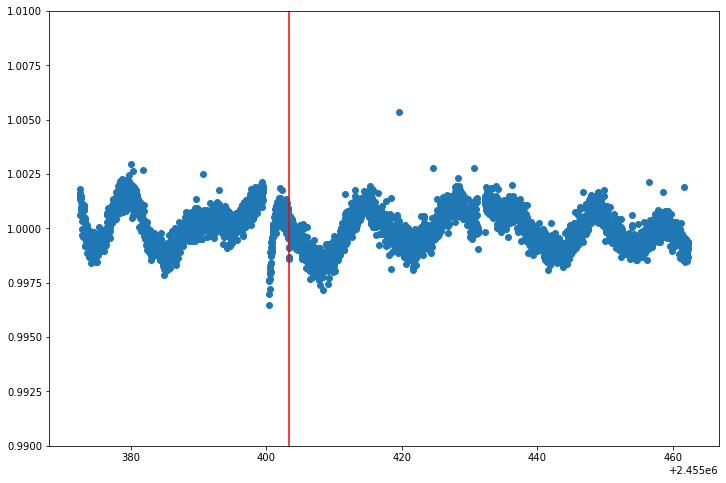

In [22]:
plt.scatter(time, flux)
plt.axvline(transitmid, c='r')
plt.ylim(.990, 1.010)

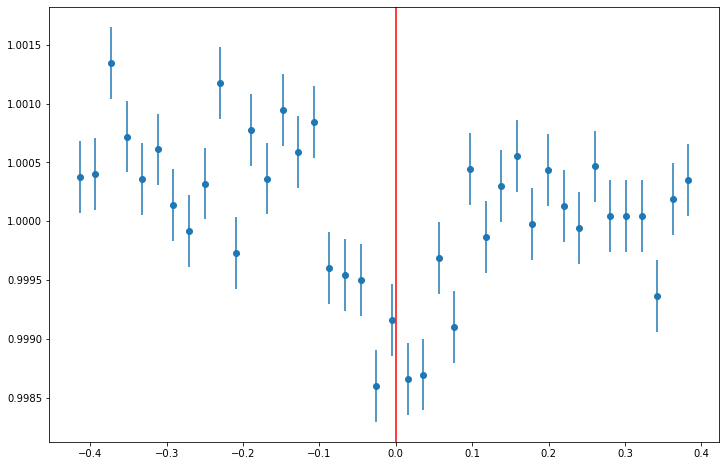

In [23]:
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')


In [24]:
idx = np.isfinite(t1) & np.isfinite(f1)

disc = 15

m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)

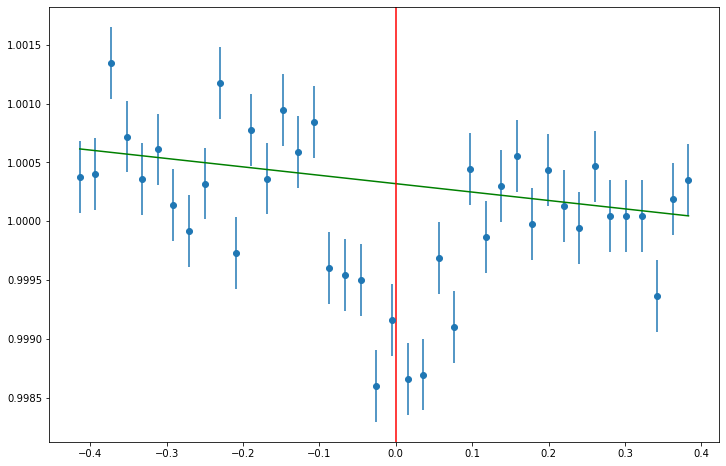

In [25]:
plt.plot(t1, m*t1 + b, c='g')
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [26]:
linfit = m*t1 + b
fnorm = (f1-linfit)+1

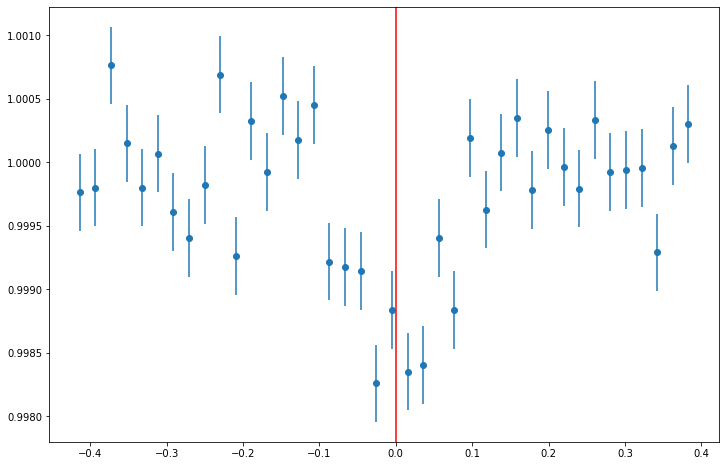

In [27]:
plt.errorbar(t1, fnorm, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [28]:
ptime = ph.get_ptime(t1, mid, 29)
fnorm = np.nan_to_num(fnorm, nan=1.0)
fe1 = np.nan_to_num(fe1, nan=1.0)

In [29]:
pdist = np.random.normal(59.9, 1, arrlen)

In [30]:
# Inital guess: rprs, a/Rs, i, w
p0 = [0.04, 90, 89.9]

dr = 'Kepler61'
direct = 'plots/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, rdist, adist, idist = ph.mcmc_fitter(p0, t1, ptime, fnorm, fe1, pdist, nwalk, nsteps_d, ndiscard_d, 'X', 'X', direct)

IndexError: list index out of range

In [31]:
# Create a light curve with the fit parameters

mcmcfit = ph.integratedlc_fitter(t1, ph.mode(pdist), ph.mode(rdist), ph.mode(adist), ph.mode(idist))

plt.errorbar(t1, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
plt.scatter(t1, mcmcfit, c='red', alpha=1.0, label='Fit LC')
plt.plot(t1, mcmcfit, c='red', alpha=1.0)

plt.legend()

NameError: name 'rdist' is not defined

In [485]:
ph.mode(rdist)

0.03281895541945362

In [486]:
ph.mode(adist)

102.14887995754547

In [487]:
ph.mode(idist)

89.97577075606185

# Kepler-1582 b

In [425]:
pname = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/MAST_2021-05-07T1328/Kepler/kplr005868793_lc_Q000000111100000000/kplr005868793-2010355172524_llc.fits'
hdu = fits.open(pname)

time = hdu[1].data['TIME'] + hdu[1].header['BJDREFI']
flux = hdu[1].data['PDCSAP_FLUX']
flux_err = hdu[1].data['PDCSAP_FLUX_ERR']



In [426]:
fmed = np.nanmedian(flux)

flux = flux/fmed
flux_err = flux_err/fmed

In [427]:
t0 = hdu[1].header['BJDREFI']
tm1 = hdu[1].header['BJDREFI']+period*100
tmidtimes = np.arange(t0, tm1, period)

In [428]:
midjd = np.genfromtxt('datafiles/keplerstellar/kep1582-mpts.txt', delimiter=' ')[1:]

In [429]:
cmtimes = []
for j in range(len(midjd)):
    if time[0] < midjd[j] < time[-1]:
        cmtimes.append(midjd[j])

In [430]:
cmtimes

[2455466.47869,
 2455471.31684,
 2455476.15499,
 2455480.99314,
 2455485.83128,
 2455490.66944,
 2455495.50758,
 2455500.34573,
 2455505.18388,
 2455510.02203,
 2455514.86018,
 2455519.69833,
 2455524.53648,
 2455529.37463,
 2455534.21278,
 2455539.05093,
 2455543.88908,
 2455548.72723]

In [441]:
transitmid = cmtimes[8]

In [442]:
start = hdu[1].header['TSTART'] + hdu[1].header['BJDREFI']
end = hdu[1].header['TSTOP'] + hdu[1].header['BJDREFI']

In [443]:
mid = ph.get_mid(time)

In [447]:
tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

n = 12

t1 = time[tindex-n:tindex+n] - transitmid
f1 = flux[tindex-n:tindex+n]
fe1 = flux_err[tindex-n:tindex+n]

(0.99, 1.01)

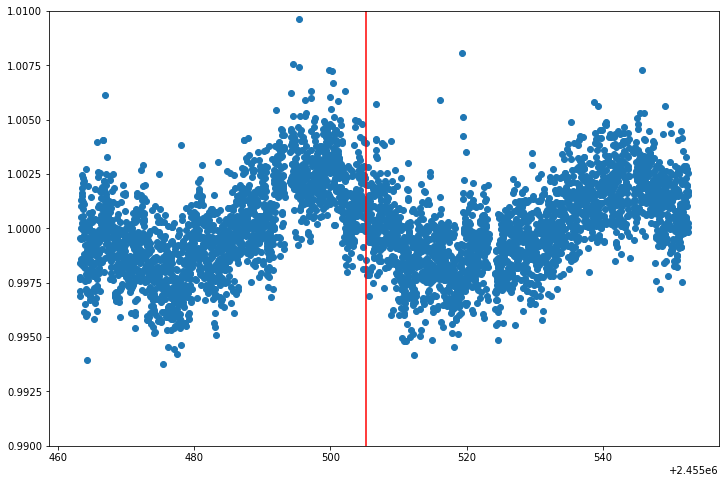

In [448]:
plt.scatter(time, flux)
plt.axvline(transitmid, c='r')
plt.ylim(.990, 1.010)

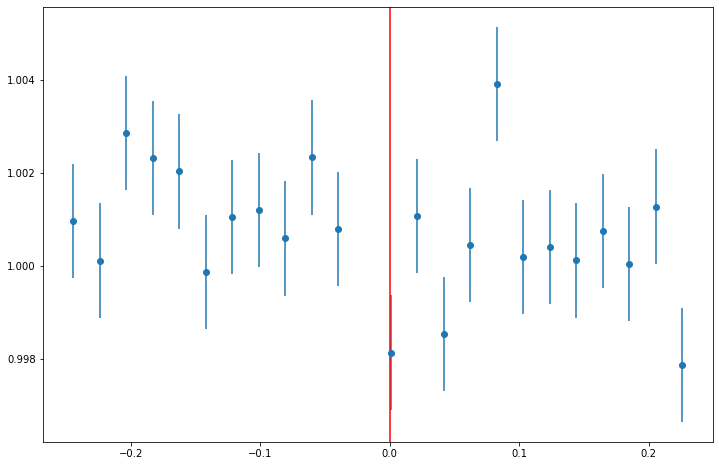

In [449]:
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')


In [450]:
idx = np.isfinite(t1) & np.isfinite(f1)

disc = 15

m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)

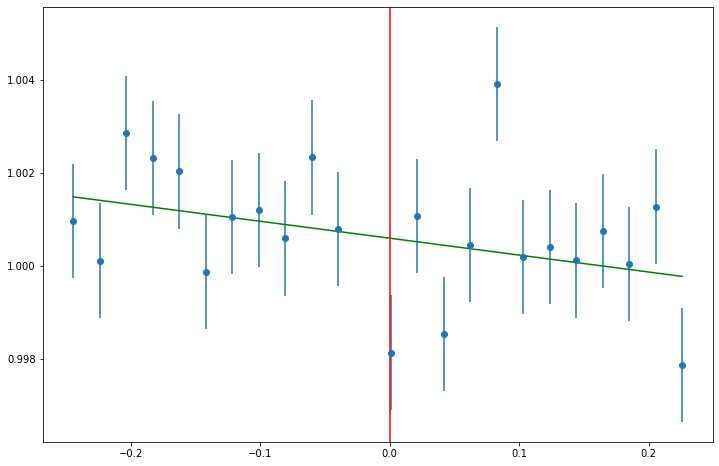

In [451]:
plt.plot(t1, m*t1 + b, c='g')
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [452]:
linfit = m*t1 + b
fnorm = (f1-linfit)+1

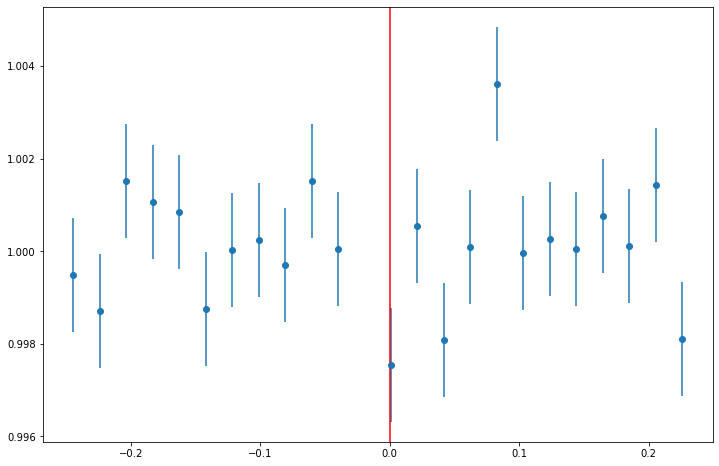

In [453]:
plt.errorbar(t1, fnorm, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [454]:
ptime = ph.get_ptime(t1, mid, 29)
fnorm = np.nan_to_num(fnorm, nan=1.0)
fe1 = np.nan_to_num(fe1, nan=1.0)

In [455]:
pdist = np.random.normal(59.9, 1, arrlen)

In [456]:
# Inital guess: rprs, a/Rs, i, w
p0 = [0.035, 32, 89.9]

dr = 'Kepler1582'
direct = 'plots/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, rdist, adist, idist = ph.mcmc_fitter(p0, t1, ptime, fnorm, fe1, pdist, nwalk, nsteps_d, ndiscard_d, 'X', 'X', direct)

100%|██████████| 500/500 [00:20<00:00, 24.21it/s]


In [457]:
ph.mode(rdist)

0.010222543423693593

In [458]:
ph.mode(adist)

1.681808001728939

In [459]:
ph.mode(idist)

0.9087167195118011

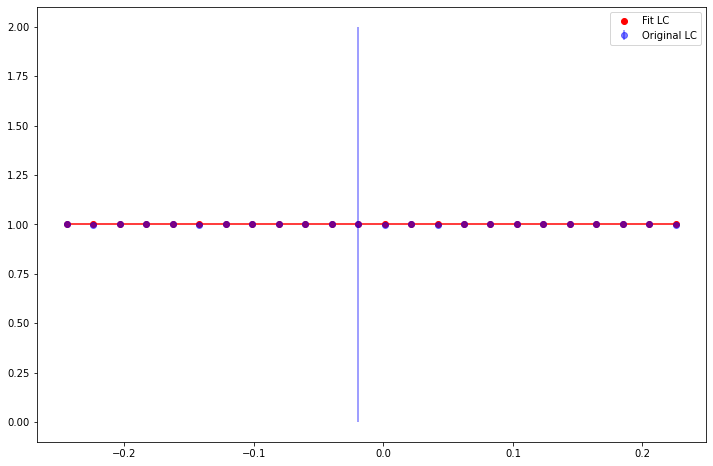

In [460]:
# Create a light curve with the fit parameters

mcmcfit = ph.integratedlc_fitter(t1, ph.mode(pdist), ph.mode(rdist), ph.mode(adist), ph.mode(idist))

plt.errorbar(t1, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
plt.scatter(t1, mcmcfit, c='red', alpha=1.0, label='Fit LC')
plt.plot(t1, mcmcfit, c='red', alpha=1.0)

plt.legend()

# Start over omg

https://emcee.readthedocs.io/en/stable/tutorials/line/

In [92]:
import batman

In [93]:
def integrate_lcfitter(time, rp, ars, inc):
    
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0                        #time of inferior conjunction
    params.per = 59.0                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = ars                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0                      #eccentricity
    params.w = 0.0                       #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    params.limb_dark = "quadratic"
    params.u = [0.5, 0.2]
    #params.limb_dark = "uniform"
    #params.u = []

    #times to calculate light curve
    ptime = get_ptime(time, 0.010217133909463882, 29)
    
    m = batman.TransitModel(params, ptime)
    
    pflux = m.light_curve(params)
    flux = array_integrated(pflux, 29)
    
    return flux

In [44]:
soln = [0.03301, 90.6, 89.9] # r, ars, i

In [45]:
def log_likelihood(theta, time, flux, fluxerr):
    rp, ars, inc = theta
    model = integrate_lcfitter(time, rp, ars, inc)
    sigma2 = fluxerr ** 2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

In [46]:
def log_prior(theta):
    rp, ars, inc = theta
    if 0.0 < rp < 1.0 and 0.0 < ars < 200.0 and 0.0 < inc < 90.0:
        return 0.0
    return -np.inf

In [47]:
def log_probability(theta, time, flux, fluxerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, fluxerr)

In [48]:
pos = soln + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t1, fnorm, fe1))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [05:35<00:00, 14.90it/s]


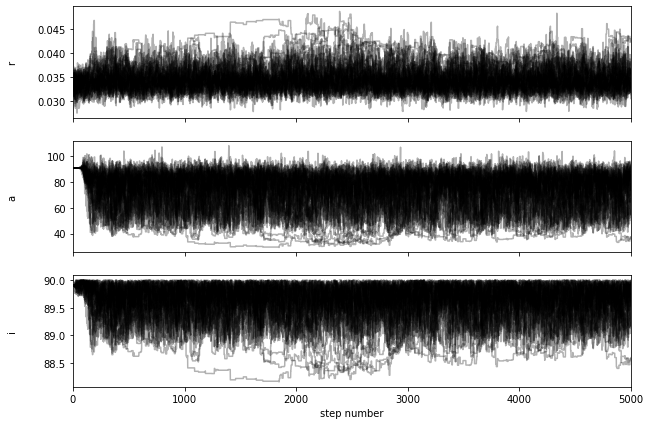

In [49]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["r", "a", "i"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [50]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [51]:
flat_samples[:1]

array([[3.42413410e-02, 8.96678995e+01, 8.99704641e+01]])

In [52]:
rprsf = np.nanmean(flat_samples[:,0])
af = np.mean(flat_samples[:,1])
incf = np.mean(flat_samples[:,2])

In [53]:
print(rprsf, af, incf)

0.03497637582580567 71.48265626404638 89.54095494597688


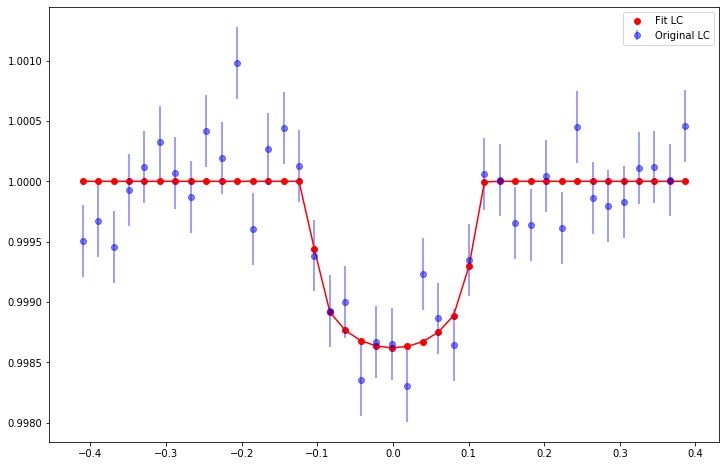

In [55]:
# Create a light curve with the fit parameters

mcmcfit = integrate_lcfitter(t1, rprsf, af, incf)

plt.errorbar(t1, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
plt.scatter(t1, mcmcfit, c='red', alpha=1.0, label='Fit LC')
plt.plot(t1, mcmcfit, c='red', alpha=1.0)

plt.legend()